In [1]:
# 데이터 불러오기, reshape
from sklearn import datasets, metrics

digits=datasets.load_digits()

df=digits.images.reshape((len(digits.images),-1))
df.shape

(1797, 64)

In [2]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(df, digits.target)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1347, 64), (450, 64), (1347,), (450,))

In [3]:
# df -> tensor , train-test set 합치기
import torch

x_train=torch.tensor(x_train, dtype=torch.float32)
x_test=torch.tensor(x_test, dtype=torch.float32)
y_train=torch.tensor(y_train, dtype=torch.long)
y_test=torch.tensor(y_test, dtype=torch.long)


from torch.utils.data import Dataset, DataLoader, TensorDataset

dataset_train = TensorDataset(x_train,y_train)
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)

dataset_test = TensorDataset(x_test,y_test)
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

(torch.Size([1347, 64]),
 torch.Size([1347]),
 torch.Size([450, 64]),
 torch.Size([450]))

In [4]:
#모델 정의
import torch.nn as nn
import torch.optim as optim


class digits_model(nn.Module):
    def __init__(self):
        super(digits_model, self).__init__()
        self.fc1 = nn.Linear(64, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 10)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = digits_model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [5]:
# loss, accuracy 기록
train_losses = []
test_accuracies = []

# 반복학습
num_epochs = 25
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloader_train:
        # 기울기 초기화
        optimizer.zero_grad()

        # loss 확인
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # 역전파, 가중치 업데트
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    # 평균 로스 기록
    train_losses.append(running_loss / len(dataloader_train))

    
    # 평가상태 변환    
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader_test:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")

print("Training complete.")

Epoch 1/25, Loss: 2.0028, Accuracy: 41.11%
Epoch 2/25, Loss: 1.4086, Accuracy: 59.56%
Epoch 3/25, Loss: 0.8543, Accuracy: 82.22%
Epoch 4/25, Loss: 0.4858, Accuracy: 91.11%
Epoch 5/25, Loss: 0.3383, Accuracy: 92.00%
Epoch 6/25, Loss: 0.2642, Accuracy: 92.00%
Epoch 7/25, Loss: 0.2250, Accuracy: 93.11%
Epoch 8/25, Loss: 0.2044, Accuracy: 94.00%
Epoch 9/25, Loss: 0.1734, Accuracy: 93.11%
Epoch 10/25, Loss: 0.1516, Accuracy: 95.11%
Epoch 11/25, Loss: 0.1623, Accuracy: 94.44%
Epoch 12/25, Loss: 0.1441, Accuracy: 95.11%
Epoch 13/25, Loss: 0.1254, Accuracy: 96.22%
Epoch 14/25, Loss: 0.1290, Accuracy: 95.33%
Epoch 15/25, Loss: 0.1064, Accuracy: 95.33%
Epoch 16/25, Loss: 0.1046, Accuracy: 96.44%
Epoch 17/25, Loss: 0.0991, Accuracy: 95.56%
Epoch 18/25, Loss: 0.0853, Accuracy: 95.33%
Epoch 19/25, Loss: 0.1105, Accuracy: 95.78%
Epoch 20/25, Loss: 0.1028, Accuracy: 95.78%
Epoch 21/25, Loss: 0.0734, Accuracy: 96.00%
Epoch 22/25, Loss: 0.0717, Accuracy: 96.67%
Epoch 23/25, Loss: 0.0686, Accuracy: 96.8

In [7]:
# 모델 평가
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# 실제 라벨, 예측값 기록
all_labels = []
all_predictions = []

model.eval()

with torch.no_grad():
    for inputs, labels in dataloader_test:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1) # 가장 확률 높은 열번호 
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# list->numpy
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

#matrix, f1, precision, recall 확인
conf_matrix = confusion_matrix(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')

# 각 specificity 확인
specificity = []
for i in range(conf_matrix.shape[0]):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]  # False Positive
    specificity.append(tn / (tn + fp))  # Specificity = TN / (TN + FP)

print(f'Confusion Matrix:\n{conf_matrix}')
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {np.mean(specificity):.2f}')

Confusion Matrix:
[[42  0  0  0  0  0  1  0  0  0]
 [ 0 49  0  0  0  0  1  0  0  0]
 [ 0  0 44  0  0  0  0  0  0  0]
 [ 0  0  0 37  0  0  0  0  1  1]
 [ 1  0  0  0 38  0  0  1  0  0]
 [ 0  0  0  0  0 53  0  0  0  0]
 [ 0  0  0  0  0  1 48  0  0  0]
 [ 0  0  0  0  0  0  0 52  1  0]
 [ 0  2  0  0  0  0  1  0 41  0]
 [ 0  0  0  0  0  1  0  0  0 34]]
F1 Score: 0.97
Precision: 0.97
Recall: 0.97
Specificity: 1.00


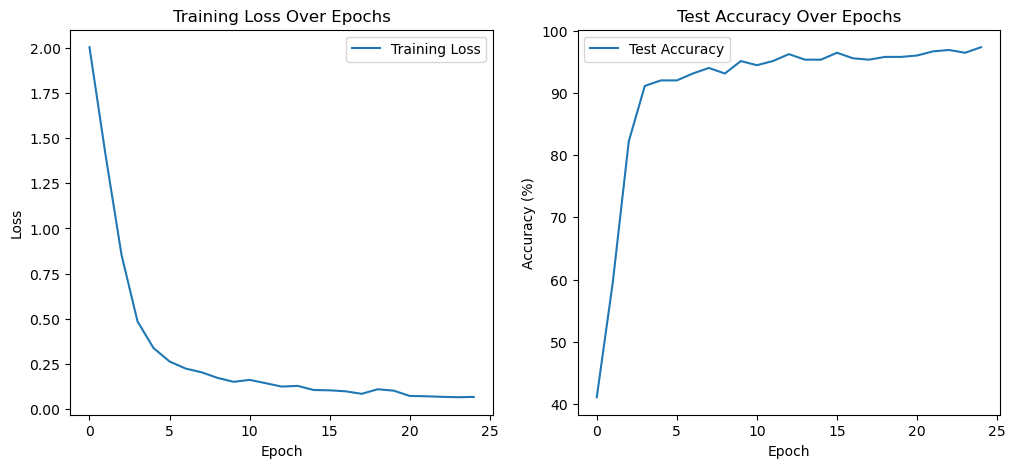

In [10]:
# loss와 accuracy 변화 확인
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.show()